In [1]:
import pandas as pd

In [2]:
import opendatasets as od

In [3]:
od.download("https://www.kaggle.com/datasets/kazanova/sentiment140")

Skipping, found downloaded files in ".\sentiment140" (use force=True to force download)


In [4]:
df_sent_train = pd.read_csv("Data/training.1600000.processed.noemoticon.csv").iloc[::-1]

In [5]:
df_sent_train.head()

,Sentiment,ID,Date,QUERY,Username,OriginalTweet
480817,4,1960158090,Fri May 29 07:30:59 PDT 2009,NO_QUERY,djbabyyu,@latinprince whats good homie!! ill be there i...
480816,4,1960158006,Fri May 29 07:30:59 PDT 2009,NO_QUERY,YUMMYBUM50,@Amanda_Holden Just looked on web to see if yo...
480815,4,1960157924,Fri May 29 07:30:58 PDT 2009,NO_QUERY,jessjohnson18,On way home blasting mcfly in the back of the ...
480814,4,1960157859,Fri May 29 07:30:58 PDT 2009,NO_QUERY,flattopgoo,@googoodolls omg that is hilarious. thanks fo...
480813,4,1960157836,Fri May 29 07:30:58 PDT 2009,NO_QUERY,danthedormant,breakfast in bed on my day off? Excellent idea


In [6]:
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)
    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lower_ for word in mytokens ]
    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]
    # return preprocessed list of tokens
    return mytokens
print(spacy_tokenizer(df_sent_train['OriginalTweet'][1]))

# Custom transformer using spaCy
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        # Cleaning Text
        return [clean_text(text) for text in X]

    def fit(self, X, y=None, **fit_params):
        return self

    def get_params(self, deep=True):
        return {}

# Basic function to clean the text
def clean_text(text):
    # Removing spaces and converting text into lowercase
    return text.strip().lower()

['@cassiefx', 'lost', 'cause', 'girl', ' ', ';)']


In [7]:
import random
from sklearn.model_selection import train_test_split

OT = df_sent_train['OriginalTweet'] # the features we want to analyze
pre_sent = df_sent_train['Sentiment'] # the labels, or answers, we want to test against

Sent = []
neg = 0
pos = 0
for rank in pre_sent:    
    if rank == 0:
        neg = neg +1
        if(neg <= pos*1.5):
            Sent.append(0)
    else: 
        Sent.append(1)
        pos = pos +1

print(pos)
print(neg)
c = list(zip(OT,Sent))
random.shuffle(c)
OT, Sent = zip(*c)
    
OT_train, OT_val, Sent_train, Sent_val = train_test_split(OT, Sent, test_size=0.15)
print(len(OT_train))
print(len(Sent_train))

248428
232390
408695
408695


In [8]:
#Precision, Recall and F1 are all based on if the tweet are classified 
#as "Not Negative" in any way
from sklearn import metrics
def report(method, predictions, truth):
    print(method)
    print("Accuracy:",metrics.accuracy_score(truth, predictions))
    print("Precision:",metrics.precision_score(truth, predictions))
    print("Recall:",metrics.recall_score(truth, predictions))
    F1 = 2*((metrics.precision_score(truth, predictions)*metrics.recall_score(truth, predictions))
            /(metrics.precision_score(truth, predictions)+metrics.recall_score(truth, predictions)))
    print("F1: ", F1)
    return [method, metrics.accuracy_score(truth, predictions), metrics.precision_score(truth, predictions), 
            metrics.recall_score(truth, predictions), F1]

In [9]:
# your code here
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(bootstrap = False, 
                            criterion = 'entropy',
                            n_estimators = 100, )
forestpipe = Pipeline([('bow',CountVectorizer()),
                     ('clf',clf)])
forestpipe.fit(OT_train[:20000],Sent_train[:20000])
predicted = forestpipe.predict(OT_val)
report("Random Forest Classifier", predicted, Sent_val)

Random Forest Classifier
Accuracy: 0.7557367275349056
Precision: 0.7690438486321193
Recall: 0.7546416610850636
F1:  0.7617746886451839


['Random Forest Classifier',
 0.7557367275349056,
 0.7690438486321193,
 0.7546416610850636,
 0.7617746886451839]

In [10]:
s1 = pd.read_csv("Data/Transcripts/MFs1CSV.csv")
s2 = pd.read_csv("Data/Transcripts/MFs2CSV.csv")
s3 = pd.read_csv("Data/Transcripts/MFs3CSV.csv")
s5 = pd.read_csv("Data/Transcripts/MFs5CSV.csv")
seasons = [s1, s2, s3, s5]

In [11]:
s1

,Name,0,1,2,3,4,5,6,7,8,...,1135,1136,1137,1138,1139,1140,1141,1142,1143,1144
0,Phil,"Phil : Yeah, just a sec.","Phil : That is so,..","Phil : Kids, get down here!","Phil : Sorry? Oh yeah, that looks really cute ...",Phil : I got it. Where's the baby oil?,Phil : Our job.,"Phil : Buddy, why do you keep getting stuck li...","Phil : There! Be free, Excalibur!",Phil : Easy. Easy.,...,Phil : Gloria.,Phil : No. No.,"Phil : You saw that, too?!","Phil : I-I got this, baby.",Phil : Kill me now.,Phil : Don't know how... I got so lucky.,Phil : I love you.,Phil : Yeah.,Phil : No. No.,Phil : Honey! Modern Family Season 1x24 page 7
1,Claire,"Claire : Kids, breakfast! Kids? Phil, would yo...",Claire : Kids!,Claire : Okay...,"Claire : Alright, That's not gonna happen, and...","Claire : Honey, do you have anything to say to...","Claire : No, it's way to short, people know yo...",Claire : It's on our bedside tip... I Don't kn...,"Claire : I... was out of control growing up, t...",Claire : Right... I've done our job.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Haley,"Haley : Why are you guys yelling at us, when w...",Haley : What's Wrong with it?,Haley : Thanks!,Haley : I'm having a friend over today.,Haley : You don't know him.,Haley : Shut up!,"Haley : His name is Dylan ... You know, I migh...","Haley : Don't answer it, I'll get it!","Haley : Hey, come on, let's go.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alex,Alex : Luke got his head stuck in the banister...,Alex : I'm just gonna say it... he needs to be...,Alex : You don't even...,Alex : And do what?,Alex : MOM! DAD!,Alex : Luke just shot me!,"Alex : No, the little bitch shot me!",Alex : What's more important here dad?,Alex : What about three?,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Luke,Luke : I thought I could get out this time.,"Luke : Oh, a boy! You gonna kiss him?",Luke : I didn't mean to!,Luke : They're only plastic bb's! It was an ac...,Luke : I'm so sorry!,"Luke : Oh, come on!",Luke : Nothing.,Luke : One ... Six.,"Luke : You're to close, it's gonna hurt.",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Gloria,Gloria : Bravo Manny! Kick it! Kick it! Manny ...,"Gloria : We're, very different. He's from the ...","Gloria : Yes, the murders.","Gloria : Manny, stop him! Stop him! Mom : Come...",Gloria : You wanna take him out? How about I t...,Gloria : Why don't you worry about your son! H...,"Gloria : Hi, I'm Gloria Pritchett... Manny's m...","Gloria : No, you're not quitting. You would ha...",Gloria : If someone says something about my fa...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Jay,"Jay : Gloria, there Owen's six, Let's take it ...",Jay : Murders.,"Jay : Honey, honey...","Jay : Her dad? Uh, no, no, that's funny. Actua...","Jay : You know Gloria, that blowup with that o...",Jay : I'm just ... saying you could take it do...,Jay : You don't have to be so emotional all th...,"Jay : Oh, for God's sake.",Jay : Hey! Watch it!,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Manny,"Manny : I'm quitting soccer, it is a game for ...","Manny : She is not a girl, She is a woman.",Manny : I wanna tell Brenda Feldman I love her.,"Manny : Oh, it's okay for you to take an older...",Manny : I want to go to the mall where she wor...,Manny : Stop the car!,Manny : Brenda Feldman.,Manny : A poem I’ve written for Brenda Feldman.,"Manny : I put my thoughts into words, and now ...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Cam,"Cameron : Sorry, sorry, sorry, Daddy needed sn...","Cameron : Then we figured, they are already me...",Cameron : You are not giving a speech ... you ...,Cameron : Mitchell!,Cameron : Mitchell!!,Cameron : She's got the cream puffs.,Cameron : We would like to pay for everyone's ...,"Cameron : Oh, stop worrying!",Cameron : I guess that's possible.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Mitch,Mitchell : Who's the good girl? Who's that?,"Mitchell : Oh, thank you!","Mitchell : Hello. Hi, hi. We've just adopted h...","Mitchell : We have been together for... five, .

In [12]:
phil = []
claire = []
haley = []
alex = []
luke = []
gloria = []
jay = []
manny = []
cam = []
mitch = []
lily = []
chars = [phil, claire, haley, alex, luke, gloria, jay, manny, cam, mitch, lily]

In [13]:
#Returns an array structured such as 
#array[Character][Season]

def Char_Sent(Characters, Data):
    row = 0
    full_p = []
    for char in Characters:
        predictions = []
        for season in Data:
            predict = forestpipe.predict(season.iloc[row].dropna())
            predictions.append(predict)
        full_p.append(predictions)
        row = row+1
    return full_p

In [14]:
chars = Char_Sent(chars, seasons)

In [15]:
#Returns an array structued as 
#array[Season][Character]
def Season_Sent(Data):
    seasonal = []
    for season in Data:
        predictions = []
        for x in range(11):
            predict = forestpipe.predict(season.iloc[x][1:].dropna())
            predictions.append(predict)
        seasonal.append(predictions)
    return seasonal

In [16]:
season_sentiments = Season_Sent(seasons)

In [46]:
def PositiveSeasonRatio(character):
    pos = 0.0 
    neg = 0.0
    for season in character:
        for sent in season:
            if sent == 0:
                neg = neg + 1.0
            else:
                pos = pos + 1.0
    return pos/(neg+pos)

In [48]:
def PositiveCharRatio(character):
    pos = 0.0 
    neg = 0.0
    for sent in character:
        if sent == 0:
            neg = neg + 1.0
        else:
            pos = pos + 1.0
    return pos/(neg+pos)

In [66]:
def full_ratio(data):
    ratios = []
        
    c_ratios = []
    for j in range(11):
        predictions = []
        total_predict = []
        for season in data:
            predict = forestpipe.predict(season.iloc[j].dropna())
            predictions.append(PositiveCharRatio(predict))
            total_predict.append(predict)
        
        predictions.append(PositiveSeasonRatio(total_predict))
        ratios.append(predictions)
        
    
    return ratios

In [62]:
def seasonal_ratio(data):
    ratios = []
    
    s_ratios = []
    j = 0
    for season in data:
        predictions = []
        for x in range(11):
            predict = forestpipe.predict(season.iloc[x][1:].dropna())
            predictions.append(predict)
        s_ratios.append(PositiveSeasonRatio(predictions))
        l = len(s_ratios)
        av = sum(s_ratios)/l
        ratios[j].append(av)
        j = j +1
    
    return ratios

In [20]:
PositiveRatio(chars[0])

0.6446280991735537

In [21]:
PositiveRatio(chars[1])

0.6267470539873938

In [22]:
PositiveRatio(chars[2])

0.5408593091828138

In [23]:
PositiveRatio(chars[3])

0.5626326963906582

In [24]:
PositiveRatio(chars[4])

0.5854398382204247

In [25]:
PositiveRatio(chars[5])

0.5910891089108911

In [26]:
PositiveRatio(chars[6])

0.5935238095238096

In [27]:
PositiveRatio(chars[7])

0.5944186046511628

In [28]:
PositiveRatio(chars[8])

0.6280193236714976

In [29]:
PositiveRatio(chars[9])

0.592871830020562

In [30]:
PositiveRatio(chars[10])

0.6153846153846154

In [67]:
character_ratios = full_ratio(seasons)

In [69]:
season_ratios = seasonal_ratio(seasons)

IndexError: list index out of range

In [68]:
character_ratios

[[0.6422338568935427,
  0.6391465677179963,
  0.6499032882011605,
  0.6573705179282868,
  0.6446280991735537],
 [0.6403985507246377,
  0.6327185244587009,
  0.6049382716049383,
  0.6285714285714286,
  0.6267470539873938],
 [0.5313531353135313,
  0.5264423076923077,
  0.5532994923857868,
  0.5945945945945946,
  0.5408593091828138],
 [0.5583333333333333,
  0.5063694267515924,
  0.616822429906542,
  0.582089552238806,
  0.5626326963906582],
 [0.5836298932384342,
  0.555921052631579,
  0.601123595505618,
  0.6666666666666666,
  0.5854398382204247],
 [0.6204506065857885,
  0.6111111111111112,
  0.551617873651772,
  0.5546875,
  0.5910891089108911],
 [0.6056511056511057,
  0.5943728018757327,
  0.5836627140974967,
  0.5778894472361809,
  0.5935238095238096],
 [0.5732484076433121,
  0.6130952380952381,
  0.6011396011396012,
  0.5675675675675675,
  0.5944186046511628],
 [0.6580027359781122,
  0.6187134502923977,
  0.6144578313253012,
  0.6181818181818182,
  0.6280193236714976],
 [0.57534246575

In [64]:
season_ratios

[[0.6130448416431483],
 [0.6092562337712144],
 [0.6059631689988656],
 [0.606859157654902]]

[[0.64223386 0.63914657 0.64990329 0.65737052 0.6446281 ]
 [0.64039855 0.63271852 0.60493827 0.62857143 0.62674705]
 [0.53135314 0.52644231 0.55329949 0.59459459 0.54085931]
 [0.55833333 0.50636943 0.61682243 0.58208955 0.5626327 ]
 [0.58362989 0.55592105 0.6011236  0.66666667 0.58543984]
 [0.62045061 0.61111111 0.55161787 0.5546875  0.59108911]
 [0.60565111 0.5943728  0.58366271 0.57788945 0.59352381]
 [0.57324841 0.61309524 0.6011396  0.56756757 0.5944186 ]
 [0.65800274 0.61871345 0.61445783 0.61818182 0.62801932]
 [0.57534247 0.61011236 0.58533917 0.62184874 0.59287183]]


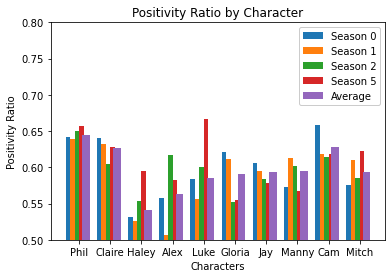

In [80]:
import matplotlib.pyplot as plt
import numpy as np

data = np.array(character_ratios[:10])
print(data)

x = np.arange(data.shape[0])
dx =(np.arange(data.shape[1])- data.shape[1]/2.)/(data.shape[1]+2.)
d = 1./(data.shape[1]+2)

fig, ax=plt.subplots()
for i in range(data.shape[1]):
    if i<3:
        ax.bar(x+dx[i], data[:,i], width=d, label = "Season {}".format(i))
    if i == 3:
        ax.bar(x+dx[i], data[:,i], width=d, label = "Season {}".format(5))
    if i == 4:
        ax.bar(x+dx[i], data[:,i], width=d+0.1, label = "Average")
plt.ylim(0.50,0.8)

plt.xlabel('Characters')
plt.ylabel('Positivity Ratio')
plt.title('Positivity Ratio by Character')
plt.xticks(x, ['Phil', 'Claire', 'Haley', 'Alex', 'Luke', 'Gloria',
                   'Jay', 'Manny', 'Cam', 'Mitch'])
plt.legend(framealpha=1)
plt.show()

TypeError: only size-1 arrays can be converted to Python scalars

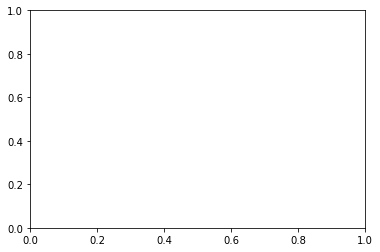

In [81]:
index = np.arange(4)
bar_width = 0.70
opacity = 0.4

rect = plt.bar(index, season_ratios, bar_width, alpha=opacity)

plt.xlabel('Season')
plt.ylabel('Positivity Ratio')
plt.title('Positivity Ratio by Season')
plt.xticks(index, ['Season 1', 'Season 2', 'Season 3', 'Season 5'])
plt.ylim(0.6,0.7)
plt.show()